# AML Homework 3: Practice


## Table of contents:
This notebook is composed of 7 Sections for 17 points

* **Section 1: Train a CNN from Scratch on CIFAR-10 ( 2 Points)**

    We will implement a Convolutional Neural Network (CNN) from the ground up to classify images from the CIFAR-10 dataset. The focus will be on understanding the architecture of CNNs, preprocessing the dataset, and optimizing the model to achieve high accuracy.

* **Section 2: Unlearning( 2 Points)**

    We introduce the concept of unlearning, which involves modifying a trained model to forget specific data points while retaining its overall performance.

* **Section 3: Gold model ( 2 Points)**

    We discuss the development of the Gold model, which serves as the benchmark for evaluating performance after implementing unlearning techniques. 


* **Section 4: Mia Attacks ( 3 Points)**

    This section will focus on MIA (Membership Inference Attacks), which are designed to determine whether a specific data point was included in the training set of a machine learning model. 
    
* **Section 5: Unlearning with KL divergence ( 2 Points)**

    This section will discuss the application of Kullback-Leibler (KL) divergence in the unlearning process, emphasizing its role in quantifying the difference between the model's original and modified predictions.

* **Section 6: GMN for Unlearning ( 6 Points)**

    This section will introduce the use of Graph Meta Networks (GMNs) in the unlearning process, highlighting their ability to adaptively modify model parameters based on specific unlearning tasks.

Do not modify parts of code that are not marked with "Your turn" or "Add your code below".

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import random
from sklearn import linear_model, model_selection
from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph
import torch.nn.functional as F


#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] Impossibile trovare la procedura specificata
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Section 1: Train from scratch a CNN on CIFAR-10

### 1.1: Model definition

In [2]:
def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        
        nn.Linear(32, 10)
    )
    
    return model

### 1.2 DataLoader


#### Your turn ( 1 Point)

Calculate the mean and the standard deviation vectors to be used in cifar_transforms  rounding the values to four decimal places.

In [3]:
import numpy as np
from torchvision import datasets, transforms

# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''
# Compute the mean and standard deviation for each channel
images = torch.stack([img for img, _ in train_dataset]) # (N x C x W x H)
mean = torch.mean(images, (0, 2, 3))
std = torch.std(images, (0, 2, 3))

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

Files already downloaded and verified
Mean:  tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


In [4]:
# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std), # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)  
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)  

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

### 1.3 See the data

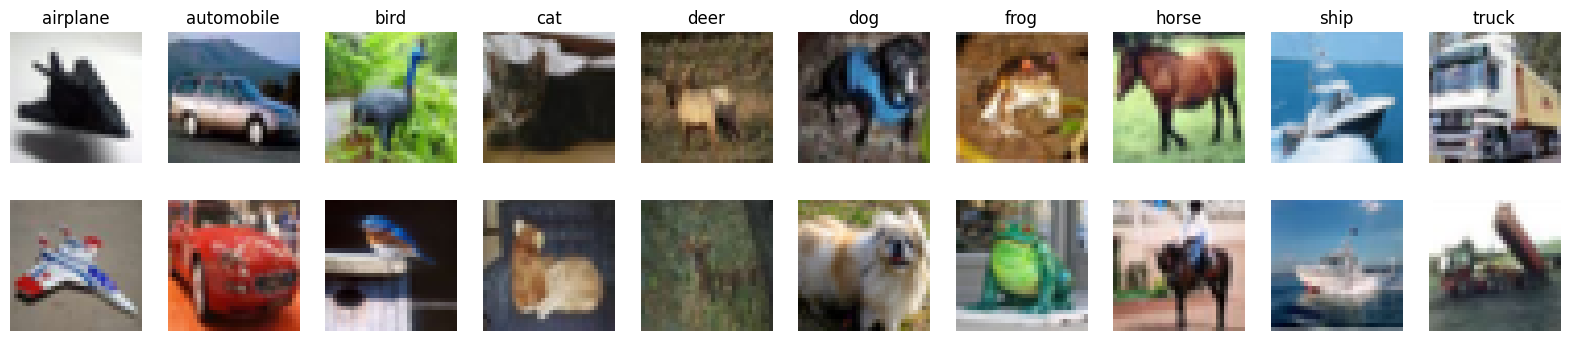

In [6]:
# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)]
    axs[1, i].imshow(img)
    axs[1, i].axis('off')

### 1.4: Training Loop

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load weights
model = create_model()
model.load_state_dict(torch.load('checkpoint/model_weights.pth'))  
model.to(device);

# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20


In [8]:
# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    model.train()
    running_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    
    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    #scheduler 
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")



Epoch [1/20]: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s, loss=1.58]


Epoch [1/20], Average Loss: 1.8914
Validation Loss: 1.5897


Epoch [2/20]: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s, loss=1.38]


Epoch [2/20], Average Loss: 1.4626
Validation Loss: 1.3830


Epoch [3/20]: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s, loss=1.28]


Epoch [3/20], Average Loss: 1.3151
Validation Loss: 1.2020


Epoch [4/20]: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s, loss=1.17]


Epoch [4/20], Average Loss: 1.2400
Validation Loss: 1.1537


Epoch [5/20]: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s, loss=1.17]


Epoch [5/20], Average Loss: 1.1886
Validation Loss: 1.2420


Epoch [6/20]: 100%|██████████| 98/98 [00:15<00:00,  6.31it/s, loss=1.19]


Epoch [6/20], Average Loss: 1.1518
Validation Loss: 1.0748


Epoch [7/20]: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s, loss=1.13]


Epoch [7/20], Average Loss: 1.1174
Validation Loss: 1.0018


Epoch [8/20]: 100%|██████████| 98/98 [00:15<00:00,  6.29it/s, loss=1.06] 


Epoch [8/20], Average Loss: 1.0865
Validation Loss: 1.0415


Epoch [9/20]: 100%|██████████| 98/98 [00:15<00:00,  6.31it/s, loss=1.08] 


Epoch [9/20], Average Loss: 1.0765
Validation Loss: 1.1650


Epoch [10/20]: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s, loss=1.11] 


Epoch [10/20], Average Loss: 1.0516
Validation Loss: 1.0879


Epoch [11/20]: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s, loss=1]    


Epoch [11/20], Average Loss: 1.0341
Validation Loss: 0.9875


Epoch [12/20]: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s, loss=0.943]


Epoch [12/20], Average Loss: 1.0233
Validation Loss: 0.9682


Epoch [13/20]: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s, loss=1.1]  


Epoch [13/20], Average Loss: 1.0042
Validation Loss: 0.9752


Epoch [14/20]: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s, loss=0.982]


Epoch [14/20], Average Loss: 0.9886
Validation Loss: 1.0103


Epoch [15/20]: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s, loss=0.972]


Epoch [15/20], Average Loss: 0.9764
Validation Loss: 0.8809


Epoch [16/20]: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s, loss=0.911]


Epoch [16/20], Average Loss: 0.9602
Validation Loss: 0.9065


Epoch [17/20]: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s, loss=1.01] 


Epoch [17/20], Average Loss: 0.9547
Validation Loss: 0.9171


Epoch [18/20]: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s, loss=0.913]


Epoch [18/20], Average Loss: 0.9414
Validation Loss: 0.8813


Epoch [19/20]: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s, loss=0.943]


Epoch [19/20], Average Loss: 0.9347
Validation Loss: 0.8255


Epoch [20/20]: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s, loss=0.928]


Epoch [20/20], Average Loss: 0.9188
Validation Loss: 0.8898


Best validation loss: 0.8255


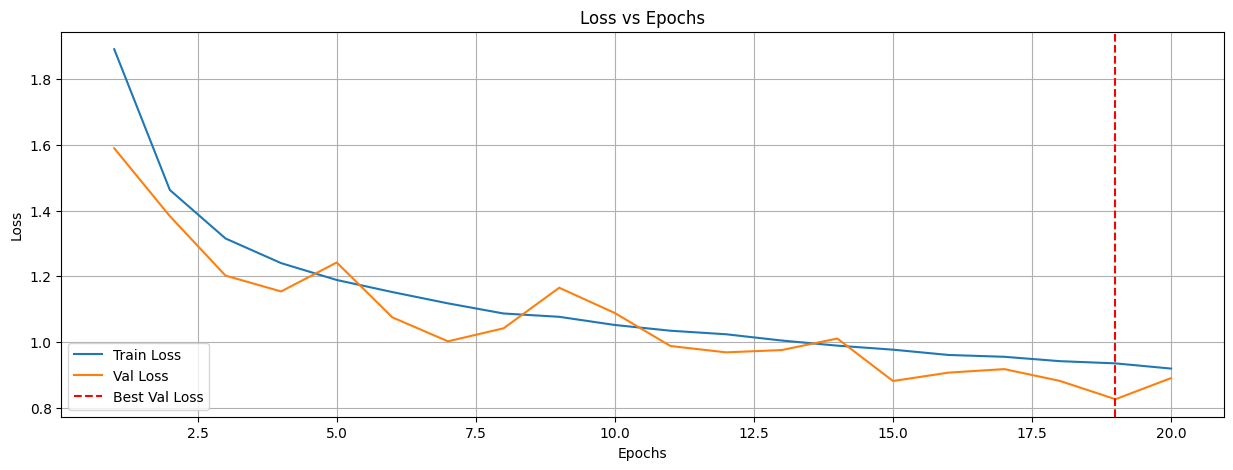

In [9]:
# Plot the losses after training
# epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

#### Your Turn (1 point)

**Question**

Q: *Based on what you've learned in the lectures and by examining the image above, identify the problems with this plot and explain how to fix them.*

A: From the plot we can see that the model do not converge very well, and the validation accuracy is a little bit noisy. As a first naive strategy, one could try to train for longer (say 40 epochs), but the results do not improve so much, as we can see in the following plots:

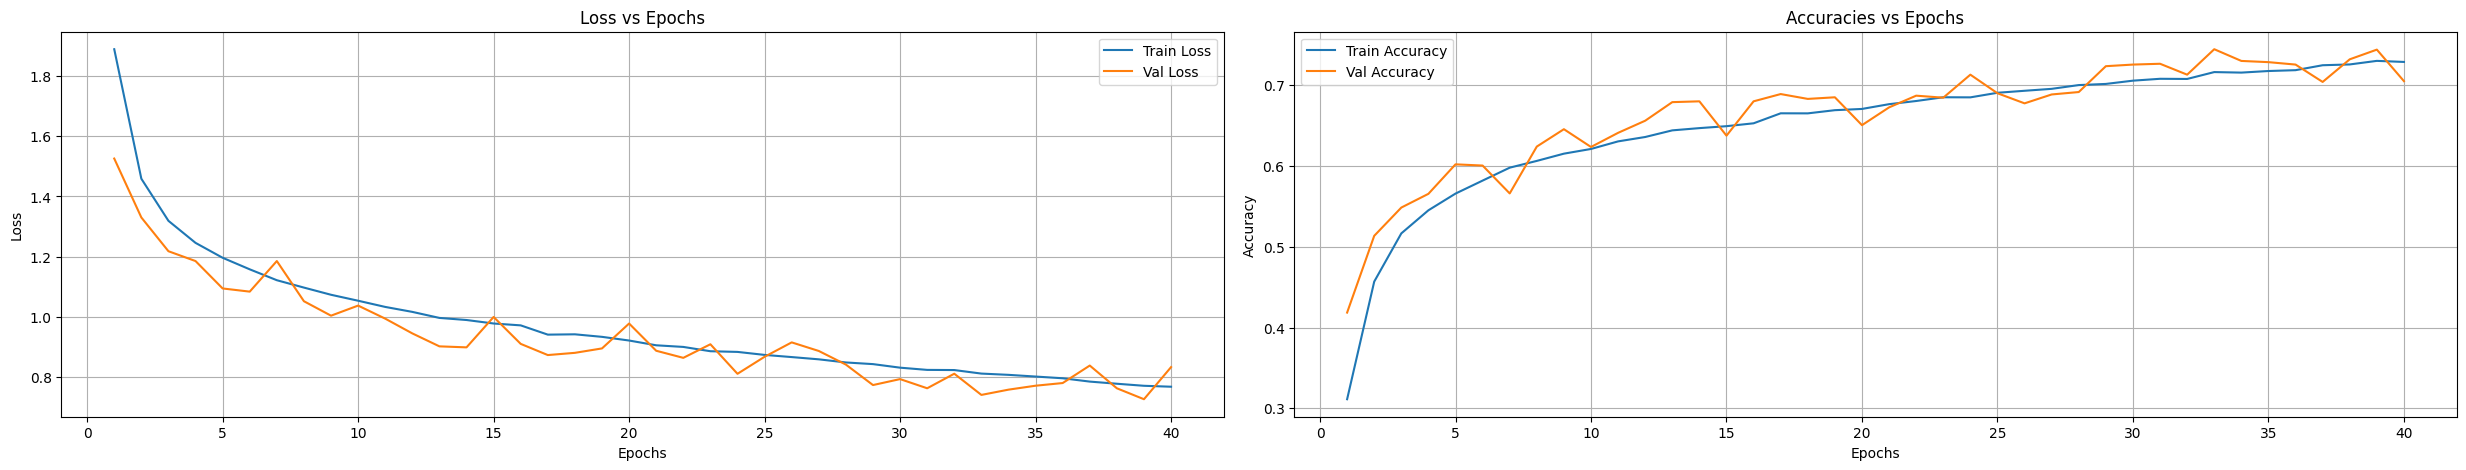

Similar results are obtained with smaller or higher learning rates, proving that the source of the problems has to be searched in other aspects of our training.

Looking at the batch size, we can see how it is a pretty large number. Even if large batches better approximate the gradients, with a too high batch size we are doing less updates in an epoch, and so the model requires much more epochs to converge. With a smaller batch size (equal 16), with the drawback of a little bit longer training, we obtain in 20 epochs much better results, as it is shown in the following plots:

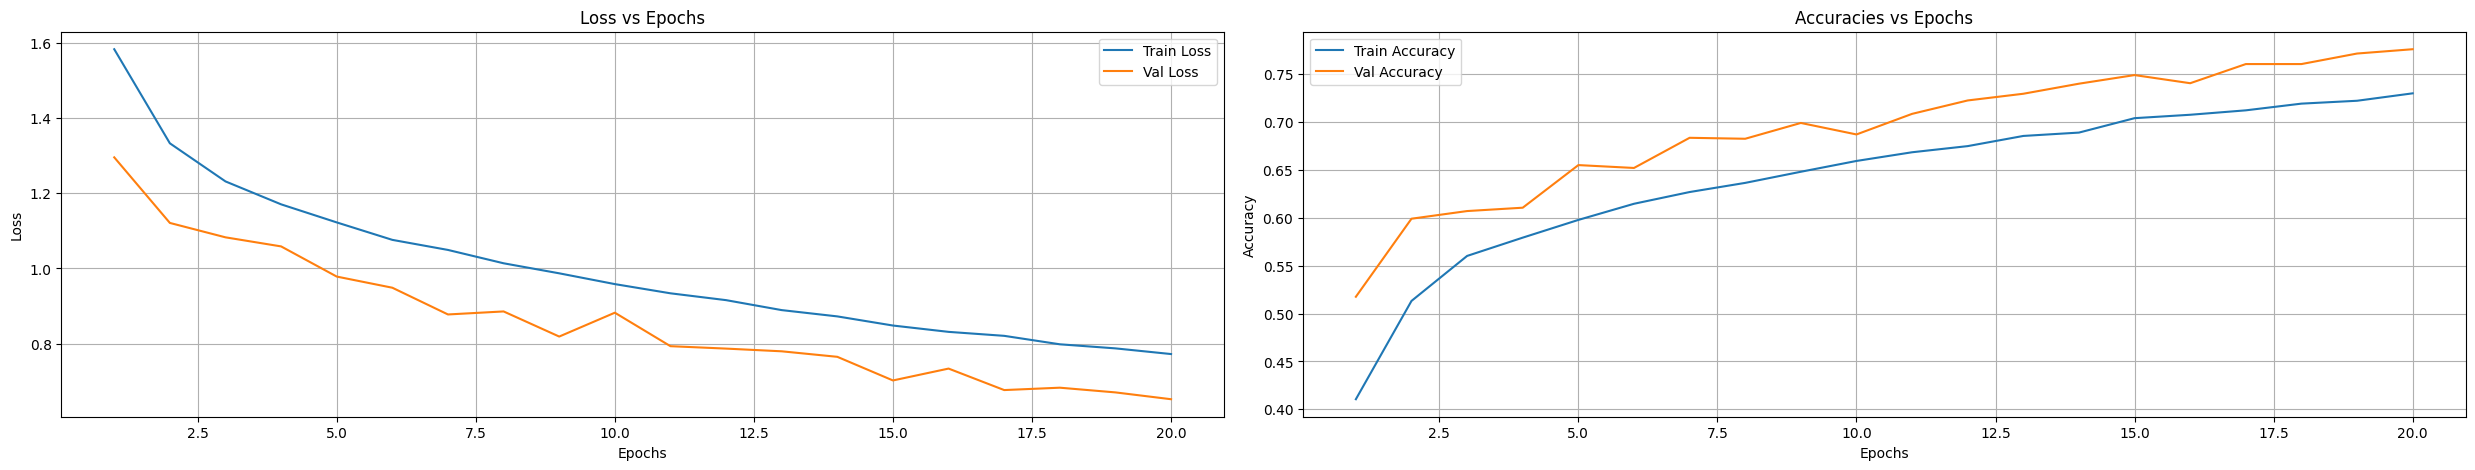

### 1.5 Evaluation

Now, let's evaluate the performances of our model

In [27]:
# accuracy 
def accuracy (model, loader):
    '''
    Function to calculate the accuracy of the model on the test set
    '''
    correct = 0
    total = 0
    for data, targets in loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.shape[0]
    return correct / total

In [60]:
# your model 
model = create_model()
model.load_state_dict(torch.load('checkpoint/trained_model.pth'))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set 
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

Your Model Train Accuracy : 80.7340
Your Model Test Accuracy : 77.0125


To avoid training for too many epochs, here it is a checkpoint you can use for the trained model.

In [12]:
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"))
model.eval()
model.to(device)

# Calculate the accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {100* train_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")

Train accuracy: 86.3860
Test Accuracy: 80.9125


# Section 2: Unlearning 

In the context of machine learning, unlearning refers to the process of modifying a trained model so that it forgets specific pieces of information without losing the general performance. This is particularly important in situations where data privacy is a concern, such as when sensitive information is involved, or when a model has learned from outdated or incorrect data. In this scenario, 
you may want to unlearn an entire class of data, a specific instance within that class, or even a particular concept that the model has learned. 

**Why is Unlearning Important?**

Let’s say you have trained a machine learning model to recognize different types of animals based on a dataset containing images. Now, suppose that this dataset includes images of a particular cat breed that was later found to be misclassified or problematic. You might need to remove that specific information from the model to ensure it doesn't make incorrect predictions in the future.

Additionally, with privacy laws like GDPR (General Data Protection Regulation), individuals have the right to request that their personal data be removed from a model. If a model has been trained on this data, we need a way to unlearn it.

Here, our task will be to unlearn the class of Airplanes in CIFAR-10 Dataset

### Unlearning by Fine-Tuning 

The Unlearning by Fine-Tuning strategy is a technique used to remove the influence of specific data points from a trained machine learning model while preserving its performance on other, relevant data. 
Here’s a detailed explanation of how this strategy works:

#### 1. The Retain Set

The retain set consists of all the data points that you want the model to remember or continue to learn from. This set excludes the data points you want the model to forget.

####  2. Fine-Tuning Process

To perform unlearning through this strategy, you follow these steps:

- Identify and Remove the Data Points: First, identify the data points that you wish to unlearn and remove them from the training dataset.

- Prepare the Retain and Forget Set: Create a new training dataset that contains only the retain set, those data points that should be kept in the model’s knowledge, and include the remaing data in the Forget Set.

- Fine-Tuning on the Retain Set: Instead of retraining the model from scratch, you will fine-tune the existing model using the retain set. This involves using the retain set to continue training the model, typically with a lower learning rate to ensure that the model can adjust its parameters without drastically altering what it has already learned.

#### 3. Benefits of this strategy

- Efficiency: Fine-tuning on the retain set only is more efficient than retraining the model from scratch. It saves computational resources and time.

- Maintained Performance: The model retains its ability to perform well on the general dataset, as it continues to learn from the valid data in the retain set.

#### 4. Drawbacks of this strategy

- Even if more efficient than retraining the model from scratch, you still need to do a fine tuning, that could be very expensive for large or foundational models. Even finding the best hyperparameters can be costly.

- If you change samples or architecture to unlearn, you have to do the ad-hoc fine tuning again, it is not a *general* strategy.

### 2.1: Forget Airplanes

#### Your Turn ( 1 Point)

Generate the retain and forget datasets, keeping in mind that we want to forget the "airplanes" class. Afterward, create new instances of the loaders for training, validation, and testing. Make sure to use the torch.utils.data.Subset function.

In [7]:
#train
'''
Add your code below
'''
keep,forget = [],[]
for i in range(len(train_dataset)):
    if train_dataset[i][1] != 9: keep.append(i)
    else: forget.append(i)

retain_dataset = torch.utils.data.Subset(train_dataset, keep)
forget_dataset = torch.utils.data.Subset(train_dataset, forget)
retain_loader = DataLoader(retain_dataset, batch_size = batch_size, shuffle=True)
forget_loader = DataLoader(forget_dataset, batch_size = batch_size, shuffle=True)

In [8]:
#validation
'''
Add your code below
'''
keep,forget = [],[]
for i in range(len(val_dataset)):
    if val_dataset[i][1] != 9: keep.append(i)
    else: forget.append(i)

retain_dataset_val = torch.utils.data.Subset(val_dataset, keep)
forget_dataset_val = torch.utils.data.Subset(val_dataset, forget)
retain_loader_val = DataLoader(retain_dataset_val, batch_size = batch_size, shuffle=True)
forget_loader_val = DataLoader(forget_dataset_val, batch_size = batch_size, shuffle=True)

In [9]:
#test 
'''
Add your code below
'''
keep,forget = [],[]
for i in range(len(test_dataset)):
    if test_dataset[i][1] != 9: keep.append(i)
    else: forget.append(i)

retain_dataset_test = torch.utils.data.Subset(test_dataset, keep)
forget_dataset_test = torch.utils.data.Subset(test_dataset, forget)
retain_loader_test = DataLoader(retain_dataset_test, batch_size = batch_size, shuffle=True)
forget_loader_test = DataLoader(forget_dataset_test, batch_size = batch_size, shuffle=True)

### 2.2: Training Loop

In [32]:
def unlearning( model, retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []
   
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(retain_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
        
                
    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [37]:
# intialize forget model as trained model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


# Unlearn the forget set
epochs = 10
forget_model, losses, losses_val = unlearning(forget_model, retain_loader, retain_loader_val, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

C:\Users\miche\AppData\Local\Temp\ipykernel_7184\247220673.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/best_model

Epoch [1/10], Average Loss: 0.5431
Validation Loss: 0.5300


Epoch [2/10]: 100%|██████████| 88/88 [00:58<00:00,  1.49it/s, loss=0.498]


Epoch [2/10], Average Loss: 0.5255
Validation Loss: 0.5260


Epoch [3/10]: 100%|██████████| 88/88 [00:56<00:00,  1.57it/s, loss=0.536]


Epoch [3/10], Average Loss: 0.5216
Validation Loss: 0.5186


Epoch [4/10]: 100%|██████████| 88/88 [00:55<00:00,  1.59it/s, loss=0.505]


Epoch [4/10], Average Loss: 0.5130
Validation Loss: 0.5034


Epoch [5/10]: 100%|██████████| 88/88 [00:53<00:00,  1.63it/s, loss=0.507]


Epoch [5/10], Average Loss: 0.5130
Validation Loss: 0.5170


Epoch [6/10]: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s, loss=0.454]


Epoch [6/10], Average Loss: 0.5148
Validation Loss: 0.5162


Epoch [7/10]: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s, loss=0.562]


Epoch [7/10], Average Loss: 0.5118
Validation Loss: 0.5122


Epoch [8/10]: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s, loss=0.584]


Epoch [8/10], Average Loss: 0.5070
Validation Loss: 0.5081


Epoch [9/10]: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s, loss=0.539]


Epoch [9/10], Average Loss: 0.5136
Validation Loss: 0.5200


Epoch [10/10]: 100%|██████████| 88/88 [00:53<00:00,  1.63it/s, loss=0.505]


Epoch [10/10], Average Loss: 0.5094
Validation Loss: 0.5203


C:\Users\miche\AppData\Local\Temp\ipykernel_7184\4194831512.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/forget_model.pt

**Below there is the evaluation of your unlearned by fine-tuning model**

In [38]:
# load weights forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(forget_model, retain_loader)
forget_accuracy = accuracy(forget_model, forget_loader)
test_accuracy = accuracy(forget_model, test_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)
test_accuracy_forget = accuracy(forget_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}") # whole test set
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

C:\Users\miche\AppData\Local\Temp\ipykernel_7184\1861309560.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/forget_mo

Retain set Accuracy: 88.1556
Forget set Accuracy: 66.6000
Test set Accuracy: 80.2125
Test set Retain Accuracy: 82.0296
Test set Forget Accuracy: 63.3205


#### Your Turn (1 Point)

**Question**

Q: *Summarize what you have learned. Specifically, interpret the accuracy values for the retain and forget sets during training. Additionally, discuss what can be inferred from the accuracy at test time for the entire test set, as well as for the two subsets of forget and retain.*

A: The idea of unlearning, by fine tuning, is based on the model training on the data minus the class (or classes) that must be unlearned. Intuitively, by training on the remaining classes the gradients, with an appropriate learning rate, would point towards a location of the loss function where the associated weights would be less specialized for the class which wants to be unlearned. 
Regarding the values of forget and retain sets during training, it has been observed that the fine-tuned model performed slightly better than the original one, excluding the airplane class.
Moreover the test accuracy slightly decreased with respect to the original model by 0.7%, which is an acceptable tradeoff for the desired result and it also shows how the model is effectively unlearning the target class. More specifically, both retain and forget obtained a worse accuracy than the training respective sets, which is a typical tendency.

# Section 3: Gold model

One might ask, how good are the scores above? What is the best possible score? Since our goal is to approximate a model that has been trained **only on** the retain set, we'll consider that the gold standard is the score achieved by this model. Such a model is called here the *gold model*.

In [23]:
# train only on retain set
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
gold_model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gold_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

#### Your Turn ( 1 Point)

Implement the training loop for the Gold Model. Store you losses inside the ```losses``` and ```losses_val``` lists.

**IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

In [24]:
# **IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**
'''
Add your code below
'''

losses = []
losses_val = []

for epoch in range(num_epochs):
    epoch_loss = 0
    gold_model.train()
    for inputs, labels in tqdm(retain_loader, total=len(retain_loader), leave=True):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        pred = gold_model(inputs)
        loss = criterion(pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(retain_loader)
    losses.append(avg_loss)
    
    scheduler.step(avg_loss)
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    loss_val = 0
    gold_model.eval()
    with torch.no_grad():
        for inputs, labels in retain_loader_val:
            inputs = inputs.to(device)
            labels = labels.to(device)

            pred = gold_model(inputs)
            loss = criterion(pred, labels)
            loss_val += loss.item()
        
        avg_val_loss = loss_val / len(retain_loader_val)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        
        if epoch == 0:
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")


100%|██████████| 88/88 [00:12<00:00,  6.88it/s]


Epoch [1/20], Average Loss: 2.2505
Validation Loss: 2.1637


100%|██████████| 88/88 [00:13<00:00,  6.51it/s]


Epoch [2/20], Average Loss: 2.1143
Validation Loss: 2.0199


100%|██████████| 88/88 [00:13<00:00,  6.52it/s]


Epoch [3/20], Average Loss: 1.9735
Validation Loss: 1.8722


100%|██████████| 88/88 [00:13<00:00,  6.49it/s]


Epoch [4/20], Average Loss: 1.8407
Validation Loss: 1.7577


100%|██████████| 88/88 [00:13<00:00,  6.51it/s]


Epoch [5/20], Average Loss: 1.7327
Validation Loss: 1.6648


100%|██████████| 88/88 [00:13<00:00,  6.52it/s]


Epoch [6/20], Average Loss: 1.6452
Validation Loss: 1.5649


100%|██████████| 88/88 [00:13<00:00,  6.45it/s]


Epoch [7/20], Average Loss: 1.5737
Validation Loss: 1.4896


100%|██████████| 88/88 [00:13<00:00,  6.53it/s]


Epoch [8/20], Average Loss: 1.5108
Validation Loss: 1.4217


100%|██████████| 88/88 [00:14<00:00,  6.26it/s]


Epoch [9/20], Average Loss: 1.4607
Validation Loss: 1.3778


100%|██████████| 88/88 [00:13<00:00,  6.48it/s]


Epoch [10/20], Average Loss: 1.4138
Validation Loss: 1.3248


100%|██████████| 88/88 [00:13<00:00,  6.49it/s]


Epoch [11/20], Average Loss: 1.3810
Validation Loss: 1.3178


100%|██████████| 88/88 [00:13<00:00,  6.48it/s]


Epoch [12/20], Average Loss: 1.3492
Validation Loss: 1.2766


100%|██████████| 88/88 [00:13<00:00,  6.51it/s]


Epoch [13/20], Average Loss: 1.3237
Validation Loss: 1.2319


100%|██████████| 88/88 [00:13<00:00,  6.46it/s]


Epoch [14/20], Average Loss: 1.3002
Validation Loss: 1.2102


100%|██████████| 88/88 [00:13<00:00,  6.57it/s]


Epoch [15/20], Average Loss: 1.2756
Validation Loss: 1.1832


100%|██████████| 88/88 [00:13<00:00,  6.56it/s]


Epoch [16/20], Average Loss: 1.2633
Validation Loss: 1.1565


100%|██████████| 88/88 [00:13<00:00,  6.45it/s]


Epoch [17/20], Average Loss: 1.2497
Validation Loss: 1.1306


100%|██████████| 88/88 [00:13<00:00,  6.57it/s]


Epoch [18/20], Average Loss: 1.2332
Validation Loss: 1.1271


100%|██████████| 88/88 [00:13<00:00,  6.49it/s]


Epoch [19/20], Average Loss: 1.2181
Validation Loss: 1.1135


100%|██████████| 88/88 [00:13<00:00,  6.52it/s]


Epoch [20/20], Average Loss: 1.2105
Validation Loss: 1.1122


Best validation loss: 1.1122


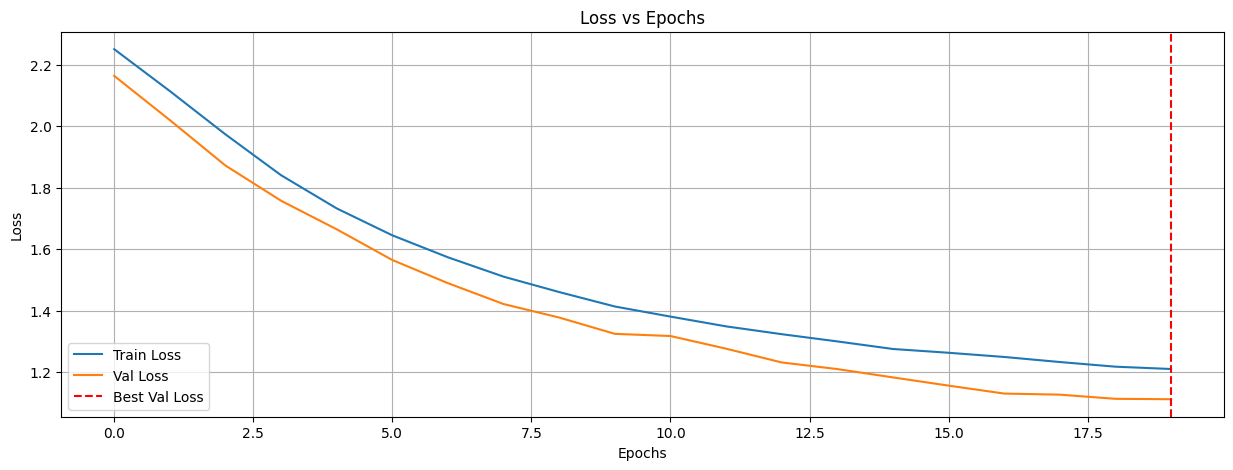

In [25]:
#epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Below there is the evaluation of the gold model**

In [28]:
# load weights gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(gold_model, retain_loader)
forget_accuracy = accuracy(gold_model, forget_loader)
test_accuracy = accuracy(gold_model, test_loader)
test_accuracy_retain = accuracy(gold_model, retain_loader_test)
test_accuracy_forget = accuracy(gold_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

Retain set Accuracy: 58.9667
Forget set Accuracy: 0.0000
Test set Accuracy: 52.4125
Test set Retain Accuracy: 58.0507
Test set Forget Accuracy: 0.0000


#### Your Turn

**Question**

Q: *Explain the results of the Gold Model. Did you notice something strange?*

A: Starting with a not trained model, result in the forget set (both training and test) to be completely misclassified, with an accuracy of 0%. Given that the model still outputs a tensor with 10 elements, each for one class, and that training was performed with just 9 classes, it learned to never output something meaningful in tenth position, because no samples had that label. The accuracies obtained on the *retain* dataset are good, but improvable (maybe longer training, smaller batch size, etc...), while accuracies on the whole *test* set are reasonably lower, because those data still have the label we haven't seen during the training, that will be misclassified, lowering the general accuracy.

# Section 5: Mia attacks

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA).
MIAs are a type of adversarial attack aimed at determining whether a specific data point was included in the training dataset of a machine learning model. These attacks exploit the behavior of the model to make inferences about the presence or absence of certain data points.
This MIA consists of a logistic regression model that predicts whether the model was trained on a particular sample from that sample's loss.



In [246]:
def compute_losses(model, loader, criterion = "CrossEntropy"):

    """
    Auxiliary function to compute per-sample losses
    Args:
    model : model to evaluate
    loader : data loader
    criterion : loss function. Specify "CrossEntropy" for cross-entropy loss or "KL" for KL divergence
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        losses = nn.CrossEntropyLoss(reduction = "none")(logits, targets).detach().cpu().numpy()
   
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


In [247]:
#model
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"));
model.eval()
model.to(device);

retain_losses = compute_losses(model, retain_loader_test)
forget_losses = compute_losses(model, forget_loader_test)


In [248]:
# forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

retain_losses_forget = compute_losses(forget_model, retain_loader_test)
forget_losses_forget = compute_losses(forget_model, forget_loader_test)


In [249]:
# gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"));
gold_model.eval()
gold_model.to(device);

retain_losses_gold = compute_losses(gold_model, retain_loader_test)
forget_losses_gold = compute_losses(gold_model, forget_loader_test)

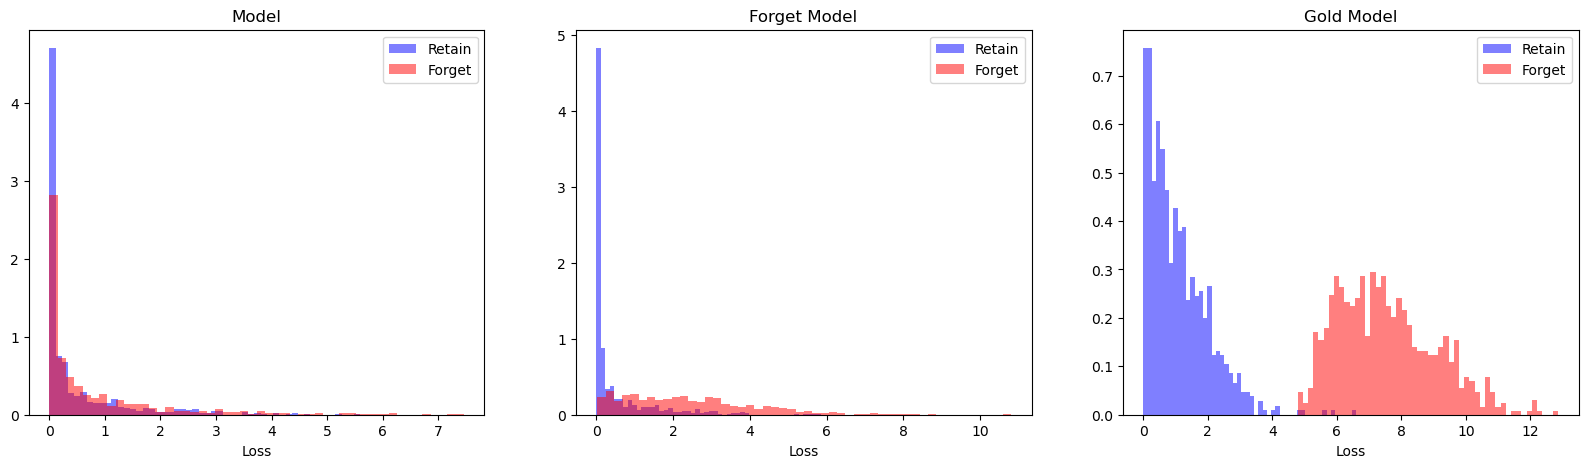

In [250]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(np.arange(len(retain_losses)), len(forget_losses), replace=False)
retain_losses = retain_losses[random_idx]
retain_losses_forget = retain_losses_forget[random_idx]
retain_losses_gold = retain_losses_gold[random_idx]


axs[0].hist(retain_losses, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[0].hist(forget_losses, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[0].set_title('Model')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].hist(retain_losses_forget, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[1].hist(forget_losses_forget, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[1].set_title('Forget Model')
axs[1].set_xlabel('Loss')
axs[1].legend()

axs[2].hist(retain_losses_gold, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[2].hist(forget_losses_gold, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[2].set_title('Gold Model')
axs[2].set_xlabel('Loss')
axs[2].legend()

plt.show()

In [80]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """
    
    torch.manual_seed(torch.initial_seed())
    
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state = 0
    )
    
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy", 
    )

In [81]:
# mia on model
retain_losses_subsample = np.random.choice(retain_losses, len(forget_losses), replace=False)
samples_mia = np.concatenate([retain_losses_subsample, forget_losses]).reshape(-1, 1)
#balance the number of samples
members_mia = np.concatenate([np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))])

scores_model = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores_model.mean():.4f}")

Model MIA score: 0.5369


In [82]:
#mia on forget model
retain_losses_forget_subsample = np.random.choice(retain_losses_forget, len(forget_losses_forget), replace=False)
samples_mia = np.concatenate([retain_losses_forget_subsample, forget_losses_forget]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_forget_subsample)), np.ones(len(forget_losses_forget))])

scores_forget = simple_mia(samples_mia, members_mia)
print(f"Forget Model MIA score: {scores_forget.mean():.4f}")

Forget Model MIA score: 0.7831


In [83]:
# mia on gold model
retain_losses_gold_subsample = np.random.choice(retain_losses_gold, len(forget_losses_gold), replace=False)
samples_mia = np.concatenate([retain_losses_gold_subsample, forget_losses_gold]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_gold_subsample)), np.ones(len(forget_losses_gold))])

scores_gold = simple_mia(samples_mia, members_mia)
print(f"Gold Model MIA score: {scores_gold.mean():.4f}")

Gold Model MIA score: 0.9963


#### Your Turn ( 3 Points)

**Question**

Q: *For each model, analyze the loss plots and explain the results obtained from the membership inference attack (MIA).*

A: ...

# 6. Unlearning with Kl divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another. In this case, to induce unlearning, we want the model's predictions on the forget set to match a uniform distribution, meaning the model "forgets" any specific information about these classes.

#### Your Turn (1 Point) 

Next, consider a simple scenario to clarify the concept: a classification problem with four classes. Here, the objective is to unlearn one class by enforcing the logits' distribution (after the softmax) to match a uniform distribution. In this case, let the target distribution for a sample coming from the forget set be $y_{gt} = [0.25, 0.25, 0.25, 0.25]$, and assume that you have achieved the predicted distribution $y_{pred} = [0.25, 0.25, 0.25, 0.25]$

**Question**

Q: *In this context, why is it preferable to use KL divergence instead of Cross-Entropy? Explain it and fill the code below in order to show it numerically.*

A: ...

In [277]:
y_gt = torch.tensor([0.25, 0.25, 0.25, 0.25])  
y_pred = torch.tensor([0.25, 0.25, 0.25, 0.25])

'''
Add your code below
'''
cross_entropy = ...
kl_div = ...

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"KL Divergence: {kl_div:.4f}")

Cross Entropy: 1.3863
KL Divergence: 0.0000


**Question**

Q: *Before proceeding, you should explain the relationship between Cross-Entropy and Kullback-Leibler (KL) divergence. Provide the proof showing how to derive the relationship between the two.*

A: ...

In [135]:
#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [205]:
def make_target (target, number_of_classes = 10):
    '''
    Function to modify the target class
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = torch.nn.functional.one_hot(target, num_classes= number_of_classes ).float().to(device)
    # Identify rows with 1 in the first position
    first_pos_mask = target == 0
    
    # Substite the rows with 1 in the first position with a uniform distribution
    n = tensor.size(1)  # Numero di colonne
    uniform_distribution = torch.full((n,), 1.0 / n, device = device)  # Distribuzione uniforme
    tensor[first_pos_mask] = uniform_distribution

    return tensor

In [206]:
def unlearning_2 (model, forget_loader, validation, epochs, optimizer, scheduler):
    '''
    Function to unlearn the forget set
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epsilon = 1e-5
    model.to(device)
    losses = []
    losses_val = []
    
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(forget_loader), total=len(forget_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs + epsilon
            outputs = F.log_softmax(outputs, dim=1)
            
            targets = make_target(targets)
            loss = F.kl_div(outputs, targets, reduction='batchmean')
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(forget_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                scores = scores + epsilon
                scores = F.log_softmax(scores, dim=1)
                targets = make_target(targets)
                loss = F.kl_div(scores, targets, reduction='batchmean')
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
    return model, losses, losses_val

In [ ]:
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"));
another_forget_model.to(device);

# optimizer
optimizer = torch.optim.Adam(another_forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 10

forget_loader = forget_loader
val_loader = forget_loader_val

another_forget_model, losses, losses_val = unlearning_2(another_forget_model, forget_loader, val_loader, num_epochs, optimizer, scheduler)

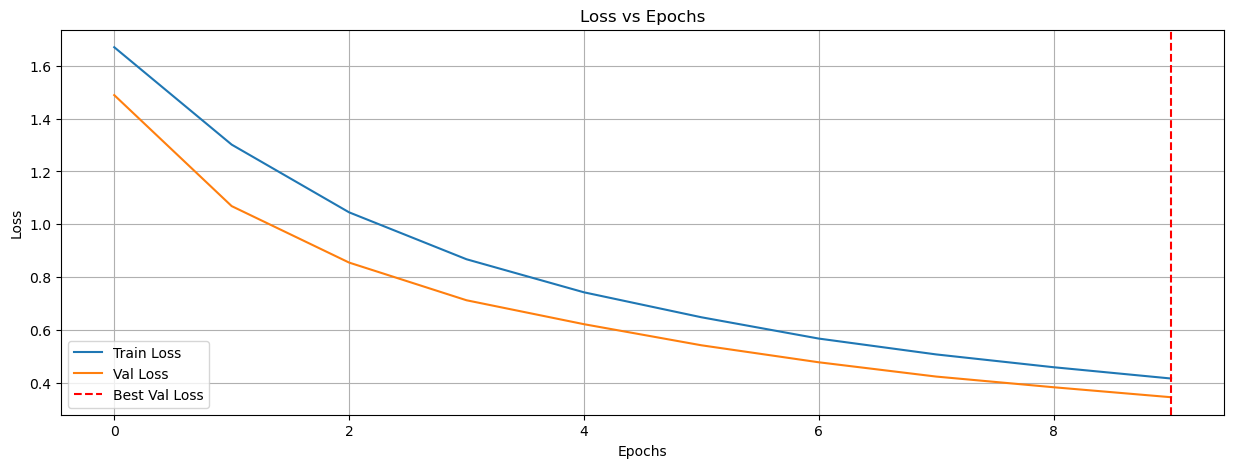

In [209]:
#plot losses
#epoch of best validation loss
index_best = losses_val.index(min(losses_val))

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [210]:
# calculate accuracy 
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))
another_forget_model.eval()
another_forget_model.to(device)


# Calculate the accuracy on the test set
retain_accuracy = accuracy(another_forget_model, retain_loader)
forget_accuracy = accuracy(another_forget_model, forget_loader)
test_accuracy = accuracy(another_forget_model, test_loader)
retain_test_accuracy = accuracy(another_forget_model, retain_loader_test)
forget_test_accuracy = accuracy(another_forget_model, forget_loader_test)

In [211]:
# print accuracies on retain, forget and test set
print(f"Retain Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget Accuracy: {100* forget_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")
print(f"Test Retain Accuracy: {100* retain_test_accuracy:.4f}")
print(f"Test Forget Accuracy: {100* forget_test_accuracy:.4f}")

Retain Accuracy: 63.9822
Forget Accuracy: 17.3800
Test Accuracy: 56.5875
Test Retain Accuracy: 61.3750
Test Forget Accuracy: 15.0000


In [258]:
# calculate losses of the model on forget and retain test set
retain_losses_CE = compute_losses(another_forget_model, retain_loader_test)
forget_losses_CE = compute_losses(another_forget_model, forget_loader_test)

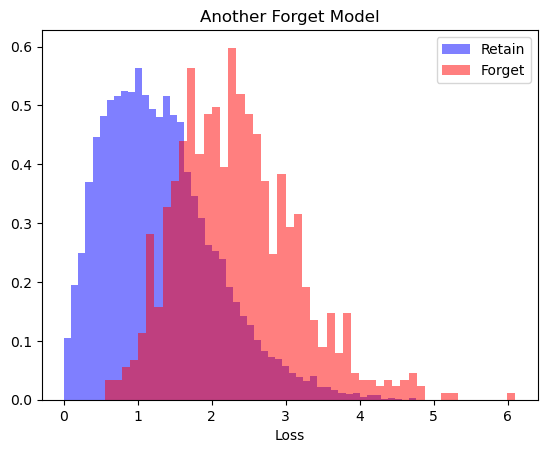

In [264]:
plt.hist(retain_losses_CE, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
plt.hist(forget_losses_CE, density = True, bins=50, alpha=0.5, label='Forget', color='red')
plt.title('Another Forget Model')
plt.xlabel('Loss')
plt.legend()
plt.show()

In [261]:
# mia attack on cross entropy
np.random.seed(0)
subsample_retain_losses_CE = np.random.choice(retain_losses_CE, len(forget_losses), replace=False)
samples_mia = np.concatenate([subsample_retain_losses_CE, forget_losses_CE]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(subsample_retain_losses_CE)), np.ones(len(forget_losses))])

scores_another_forget = simple_mia(samples_mia, members_mia)
print(f"Another Forget Model MIA score with Cross Entropy losses: {scores_another_forget.mean():.4f}")

Another Forget Model MIA score with Cross Entropy losses: 0.7556


This is another way of performing unlearning, you may have noticed that the distributions of the retain and forget sets are different but still there is an overlapping portion. It is very likely that the MIA attack will fail in that specific region.

# GMN for unlearning (6 Points)

Now, we will attempt to use the GMN you have implemented in the theory notebook for the unlearning task. Keep in mind that this is a novel and challenging task, and it is quite possible that the results may not meet your expectations. However, this is the nature of research. Therefore, the evaluation will focus on the clarity of your approach and your ability to justify your choices and results, rather then the result itself.

First of all, go into the ```Practice/gmn/graph_models.py``` file and replace the empty classes with what you have implemented in the second part of the theory notebook. Then, try to think about and implement an unlearning algorithm that leverages the graph metanetwork, and evaluate the unlearned model with MIA attacks and accuracy scores. It would be super cool to have a neural network (the GMN) that can take as input other pretrained neural networks and produce as output the same networks but unlearned over a specific subset of data samples.

In the end, generate a detailed report where you describe your idea, methodology and implementation. Put the most of your effort in explaining us the ideas and the intuitions that you had, since this is what we will reward. Don't be worried if results are poor, there can be many causes of this and it's not your task to solve all of them.

In [5]:
from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN

torch.manual_seed(0)

weights = torch.load("checkpoint/best_model.pth")
model = create_model()
model.load_state_dict(weights)
arch = sequential_to_arch(model)
x, edge_index, edge_attr = arch_to_graph(arch)
x = x.float()
edge_attr = edge_attr.float()

# currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u = torch.zeros(1, 8))

graph_batch = Batch.from_data_list([g_cnn])
print(graph_batch)

DataBatch(x=[216, 3], edge_index=[2, 59050], edge_attr=[59050, 6], u=[1, 8], batch=[216], ptr=[2])


In [ ]:
class GraphMetaNetwork(nn.Module):
    '''
    Wrapper class for the graph metanetwork
    '''
    def __init__(self, encoder, mpnn):
        super(GraphMetaNetwork, self).__init__()
        self.encoder = encoder
        self.mpnn = mpnn

    def forward(self, data):
        x, edge_index, edge_attr, u, batch = data.x, data.edge_index, data.edge_attr, data.u, data.batch
        x, edge_attr = self.encoder(x, edge_attr)
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return edge_attr

# Define the encoder and MPNN
pre_embedding_dim = 64
global_in_dim = 8
hidden_dim = 32
node_out_dim = 3
edge_out_dim = 1
global_out_dim = 8
num_gnn_layers = 4
encoder = NodeEdgeFeatEncoder(hidden_dim=pre_embedding_dim)
mpnn = MPNN(node_in_dim=pre_embedding_dim,
            edge_in_dim=pre_embedding_dim,
            global_in_dim = global_in_dim,
            hidden_dim=hidden_dim,
            node_out_dim= node_out_dim,
            edge_out_dim = edge_out_dim,
            global_out_dim= global_out_dim,
            num_layers=num_gnn_layers,
            reduce='mean')

# Create the metanetwork
gmn = GraphMetaNetwork(encoder, mpnn)
gmn.to(device)

If you need to convert the output of the gmn back into a neural network model (i.e., an ```nn.Sequential``` object), please look into ```graph_to_arch``` and ```arch_to_sequential``` functions stored in ```Practice/gmn/graph_construct/model_arch_graph.py```.

In [ ]:
'''
Add your code below
'''

## Report

...